In [1]:
import pandas as pd
df= pd.read_csv('SuicTweets.csv')
df.head()

tweet  intention
0  my life is meaningless i just want to end my l...          1
1  muttering i wanna die to myself daily for a fe...          1
2  work slave i really feel like my only purpose ...          1
3  i did something on the 2 of october i overdose...          1
4  i feel like no one cares i just want to die ma...          1

In [2]:
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words_en= stopwords.words('English')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def procesar_tweet(tweet):
    resultado = tweet.lower()
    resultado = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)','',resultado)
    resultado = word_tokenize(resultado)
    resultado = [token for token in resultado if token not in stop_words_en]
    resultado=[lemmatizer.lemmatize(token) for token in resultado]
    resultado = ' '.join(resultado)
    return resultado
df['tweet_clean']=df['tweet'].apply(procesar_tweet)
df.head()

tweet  intention  \
0  my life is meaningless i just want to end my l...          1   
1  muttering i wanna die to myself daily for a fe...          1   
2  work slave i really feel like my only purpose ...          1   
3  i did something on the 2 of october i overdose...          1   
4  i feel like no one cares i just want to die ma...          1   

                                         tweet_clean  
0  life meaningless want end life badly life comp...  
1  muttering wan na die daily month feel worthles...  
2  work slave really feel like purpose life make ...  
3  something 2 october overdosed felt alone horri...  
4   feel like one care want die maybe feel le lonely

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer(ngram_range=(1,1))
vectorized_text = tfidf.fit_transform(df['tweet_clean'])
vectorized_text

<9119x22584 sparse matrix of type '<class 'numpy.float64'>'
	with 275211 stored elements in Compressed Sparse Row format>

In [4]:
mapper={
    0:'Non-Suicide',
    1:'Suicide'
}
df['intention'] = df['intention'].map(mapper)
df['intention'].value_counts()

intention
Non-Suicide    5121
Suicide        3998
Name: count, dtype: int64

In [5]:
# Modelo
from sklearn.manifold import TSNE
modelo= TSNE(n_components=2, init='random')
resultado= modelo.fit_transform(vectorized_text)

In [6]:
resultado

array([[-0.14878763, -0.887749  ],
       [-1.1302484 ,  1.8165947 ],
       [ 0.9342473 ,  0.06512792],
       ...,
       [ 0.0841691 , -0.17801948],
       [-0.80315554, -1.6382    ],
       [ 1.3504083 , -0.6364087 ]], dtype=float32)

In [7]:
tsne_result_df=pd.DataFrame({'tsne_1': resultado[:,0], 'tsne_2': resultado[:,1]})
tsne_result_df['label']=df['intention']
tsne_result_df['text']=df['tweet']
tsne_result_df.head()

tsne_1    tsne_2    label  \
0 -0.148788 -0.887749  Suicide   
1 -1.130248  1.816595  Suicide   
2  0.934247  0.065128  Suicide   
3  2.774317 -0.974940  Suicide   
4 -2.128902  3.150421  Suicide   

                                                text  
0  my life is meaningless i just want to end my l...  
1  muttering i wanna die to myself daily for a fe...  
2  work slave i really feel like my only purpose ...  
3  i did something on the 2 of october i overdose...  
4  i feel like no one cares i just want to die ma...

In [8]:
import plotly_express as px
fig = px.scatter(data_frame=tsne_result_df,
                 x= tsne_result_df['tsne_1'],
                 y= tsne_result_df['tsne_2'],
                 color= tsne_result_df['label'],
                 template= 'plotly_dark',
                 hover_data=['text'])
fig.show()

# Regresión Logistica

In [9]:
from sklearn.model_selection import train_test_split
#Variable de entrenamiento
X = df['tweet_clean']
y = df['intention']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75, random_state=101)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
#Calcula la matriz de tfdif
X_train_vectorized = tfidf.fit_transform(X_train)
#Calculamos los pesos sin modificar la matriz original
X_test_vectorized = tfidf.transform(X_test)

In [11]:
from sklearn.linear_model import LogisticRegression

model= LogisticRegression()
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

In [12]:
y_pred 

array(['Suicide', 'Suicide', 'Non-Suicide', ..., 'Non-Suicide', 'Suicide',
       'Suicide'], dtype=object)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Non-Suicide       0.89      0.94      0.91      1295
     Suicide       0.92      0.84      0.88       985

    accuracy                           0.90      2280
   macro avg       0.90      0.89      0.90      2280
weighted avg       0.90      0.90      0.90      2280



<Axes: >

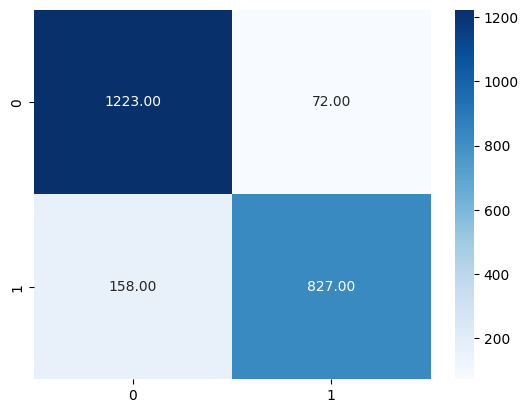

In [14]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='.2f')

In [15]:
tweet_nuevo = 'I like maths'
def predecir_tweet(tweet):
    resultado = procesar_tweet(tweet)
    resultado = tfidf.transform([resultado])
    prediccion = model.predict(resultado)
    probabilidad = model.predict_proba(resultado) # Primer lugar el valor de la clase No Suicida y segundo lugar el valor de la clase Suicida
    return (prediccion, probabilidad)

predecir_tweet(tweet_nuevo)

(array(['Non-Suicide'], dtype=object), array([[0.8965101, 0.1034899]]))